In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2

from tqdm import tqdm

from resnet import ResNet18
from attack import FGSM, IFGSM, LLFGSM

In [2]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda:7')
    print(torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
device

TITAN RTX


device(type='cuda', index=7)

In [3]:
batch_size = 128
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def load_data():    
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
    transform_test = transforms.Compose([transforms.ToTensor()])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    dataset = {'train': trainset, 'test': testset}
    data_loader = {'train': train_loader, 'test': test_loader}
    return dataset, data_loader

def load_iter(data_loader, data_type):
    bar_format = '{bar:30} {n_fmt}/{total_fmt} [{elapsed}<{remaining} {rate_fmt}] {desc}'
    
    if data_type == 'train':
        train_loader = data_loader['train']
        train_iter = tqdm(enumerate(train_loader), total=len(train_loader), unit_scale=batch_size, bar_format=bar_format)
        return train_iter
    elif data_type == 'test':
        test_loader = data_loader['test']
        test_iter = tqdm(enumerate(test_loader), total=len(test_loader), unit_scale=batch_size, bar_format=bar_format)
        return test_iter
    else:
        print('Data Error!!!')

In [40]:
def imshow(img, name):
    img = img.cpu().detach()
    img = np.asarray(img, dtype='int64')
    img = np.transpose(img, (1, 2, 0))
    cv2.imwrite(f'./images/{name}.png', img[:, :, [2, 1, 0]])
    plt.imshow(img)
    plt.show()

In [5]:
def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    step = 0
    train_iter = load_iter(data_loader, 'train')
    for i, (batch, label) in train_iter:
        batch, label = batch.to(device), label.to(device)
        output = model(batch)
        
        optimizer.zero_grad()
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()

        acc = 100. * correct / total
        train_iter.set_description(f'[{acc:.2f}% ({correct}/{total})]', True)

In [6]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    acc = 0.
    test_iter = load_iter(data_loader, 'test')

    for i, (batch, label) in test_iter:
        batch, label = batch.to(device), label.to(device)
        batch = 255. * batch
        
        output = model(batch)
        loss = loss_function(output, label)
        
        test_loss += loss.item()
        _, predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()

        acc = 100. * correct / total
        test_iter.set_description(f'[{acc:.2f}%({correct}/{total})]', True)
    return acc

In [42]:
def adv_attack(model, atk):
    model.eval()
    correct = 0
    total = 0
    acc = 0.
    test_iter = load_iter(data_loader, 'test')

    for i, (batch, label) in test_iter:
        batch, label = batch.to(device), label.to(device)
        batch = 255. * batch
        
        adv_batch = atk(batch, label, model, loss_function)
        
        if i == 0:
            idx = 10
            imshow(batch[idx], 'original')
            imshow(adv_batch[idx], str(atk).split('.')[1].split(' ')[0])
        
        output = model(adv_batch)
        
        _, predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        acc = 100. * correct / total
        
        test_iter.set_description(f'[{acc:.2f}%({correct}/{total})]', True)
    return acc

In [8]:
def save_model(epoch, acc, optimizer):
    global best_acc
    if acc > best_acc:
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'optimizer': optimizer.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/model_{epoch}.pth')
        best_acc = acc
        print('Saving Model...')

def load_model(name):
    state_dict = torch.load(f'./models/{name}.pth', map_location=device)
    model = ResNet18()
    model.to(device)
    model.load_state_dict(state_dict['model'])
    optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
#     optimizer.load_state_dict(state_dict['optimizer'])
    return model, optimizer

In [38]:
model, optimizer = load_model('baseline2')
loss_function = nn.CrossEntropyLoss()
dataset, data_loader = load_data()

Files already downloaded and verified
Files already downloaded and verified


                               0/10112 [00:00<? ?it/s] 

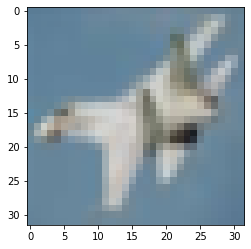

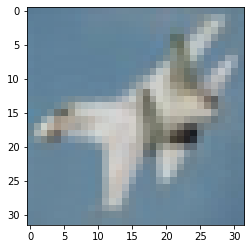

██████████████████████████████ 10112/10112 [00:48<00:00 209.86it/s] [68.06%(6806/10000)]: 


68.06

In [53]:
# atk = FGSM(epsilon=2, device=device)
# atk = IFGSM(alpha=0.1, epsilon=5, n_iteration=10, device=device)
atk = LLFGSM(alpha=0.1, epsilon=5, n_iteration=10, device=device)

# test(model)
adv_attack(model, atk)